# Introducción

## Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xml.etree.ElementTree as ET


import string
from wordfreq import word_frequency
from collections import Counter
from nltk.corpus import stopwords
import nltk

from scipy.stats import pearsonr, spearmanr, linregress

## Funciones de varios usos

In [2]:
# Usar stopwords para evitar palabras que no aportan información
stop_words = set(stopwords.words('english'))

# Función para obtener la frecuencia en inglés de todas las palabras únicas en una categoría
def obtener_frecuencias_ingles_por_categoria(df, categoria, ascending=False):
    preguntas = df[df['category'] == categoria]['question'].dropna().str.lower()
    palabras = set(' '.join(preguntas).split())
    
    # Filtrar: quitar stopwords y palabras que contienen símbolos/puntuación
    palabras_filtradas = [
        word.strip(string.punctuation)  # elimina ? . , ! etc.
        for word in palabras
        if word.isalpha() and word not in stop_words
    ]
    
    frecuencias = [
        (word, word_frequency(word, 'en', wordlist='best'))
        for word in palabras_filtradas
    ]
    
    df_frecuencias = pd.DataFrame(frecuencias, columns=['word', 'english_frequency'])
    df_frecuencias['category'] = categoria
    return df_frecuencias.sort_values(by='english_frequency', ascending=ascending).reset_index(drop=True)

# Frecuencia media de palabras por oración
def obtener_frecuencia_media(sentence, lang='en'):
    if not isinstance(sentence, str):
        return 0.0
    words = sentence.lower().split()
    words = [word.strip(string.punctuation) for word in words]
    words = [word for word in words if word.isalpha() and word not in stop_words]
    freqs = [word_frequency(word, lang, wordlist='best') for word in words]
    if not freqs:
        return 0.0
    return sum(freqs) / len(freqs)

# Frecuencia mínima de palabras por oración
def obtener_frecuencia_minima(sentence, lang='en'):
    if not isinstance(sentence, str):
        return 0.0
    words = sentence.lower().split()
    words = [word.strip(string.punctuation) for word in words]
    words = [word for word in words if word.isalpha() and word not in stop_words]
    freqs = [word_frequency(word, lang, wordlist='best') for word in words]
    freqs = [f for f in freqs if f > 0]
    if not freqs:
        return 0.0
    return min(freqs)

## Carga de ficheros

In [3]:
cols_to_use = ['topic', 'question', 'category']

qrels_2020_freq = pd.read_csv("datasets/qrels/qrels_2020.csv", usecols=cols_to_use)
qrels_2021_freq = pd.read_csv("datasets/qrels/qrels_2021.csv", usecols=cols_to_use)
qrels_2022_freq = pd.read_csv("datasets/qrels/qrels_2022.csv", usecols=cols_to_use)

In [4]:
qrels_2020_freq

,topic,category,question
0,1,harmful,Can vitamin D cure COVID-19?
1,1,harmful,Can vitamin D cure COVID-19?
2,1,harmful,Can vitamin D cure COVID-19?
3,1,harmful,Can vitamin D cure COVID-19?
4,1,harmful,Can vitamin D cure COVID-19?
...,...,...,...
7251,50,helpful,Can drinking lemon water prevent COVID-19?
7252,50,helpful,Can drinking lemon water prevent COVID-19?
7253,50,helpful,Can drinking lemon water prevent COVID-19?
7254,50,helpful,Can drinking lemon water prevent COVID-19?


# Frecuencia de palabras en el idioma - Wordfreq

El siguiente paso sería comprobrar si la frecuencia de las palabras en el idioma tiene algún impacto. Para ello utilizaremos la librería wordfreq.

## Análisis de frecuencias en 2020

In [5]:

# Aplica la función para obtener frecuencias de palabras en inglés para harmful y helpful
freq_harmful_2020 = obtener_frecuencias_ingles_por_categoria(qrels_2020_freq, 'harmful', ascending=False)
freq_helpful_2020 = obtener_frecuencias_ingles_por_categoria(qrels_2020_freq, 'helpful', ascending=False)

menos_freq_harmful_2020 = obtener_frecuencias_ingles_por_categoria(qrels_2020_freq, 'harmful', ascending=True)
menos_freq_helpful_2020 = obtener_frecuencias_ingles_por_categoria(qrels_2020_freq, 'helpful', ascending=True)

print("Palabras más frecuentes en inglés (HARMFUL):")
freq_harmful_2020.head(10)

Palabras más frecuentes en inglés (HARMFUL):


,word,english_frequency,category
0,help,0.000562,harmful
1,high,0.000562,harmful
2,water,0.000331,harmful
3,social,0.000263,harmful
4,cause,0.000224,harmful
5,light,0.000214,harmful
6,c,0.000214,harmful
7,wearing,0.000071,harmful
8,prevent,0.000062,harmful
9,treat,0.000056,harmful


In [6]:
print("Palabras menos frecuentes en inglés (HARMFUL):")
menos_freq_harmful_2020.head(10)

Palabras menos frecuentes en inglés (HARMFUL):


,word,english_frequency,category
0,arbs,5.890000e-08,harmful
1,ivig,7.240000e-08,harmful
2,tamiflu,7.940000e-08,harmful
3,hib,1.070000e-07,harmful
4,echinacea,1.380000e-07,harmful
5,pneumococcal,1.740000e-07,harmful
6,convalescent,3.980000e-07,harmful
7,ayurveda,4.070000e-07,harmful
8,sanitizer,5.010000e-07,harmful
9,monoclonal,7.080000e-07,harmful


In [7]:
print("\nPalabras más frecuentes en inglés (helpful):")
freq_helpful_2020.head(10)


Palabras más frecuentes en inglés (helpful):


,word,english_frequency,category
0,high,0.000562,helpful
1,help,0.000562,helpful
2,getting,0.000372,helpful
3,water,0.000331,helpful
4,black,0.000288,helpful
5,social,0.000263,helpful
6,cause,0.000224,helpful
7,c,0.000214,helpful
8,light,0.000214,helpful
9,type,0.000186,helpful


In [8]:
print("Palabras menos frecuentes en inglés (HELPFUL):")
menos_freq_helpful_2020.head(10)

Palabras menos frecuentes en inglés (HELPFUL):


,word,english_frequency,category
0,remdesivir,1.350000e-08,helpful
1,arbs,5.890000e-08,helpful
2,hydroxychloroquine,6.310000e-08,helpful
3,ivig,7.240000e-08,helpful
4,tamiflu,7.940000e-08,helpful
5,dextromethorphan,8.130000e-08,helpful
6,hib,1.070000e-07,helpful
7,handwashing,1.290000e-07,helpful
8,echinacea,1.380000e-07,helpful
9,gargling,1.580000e-07,helpful


### Histogramas

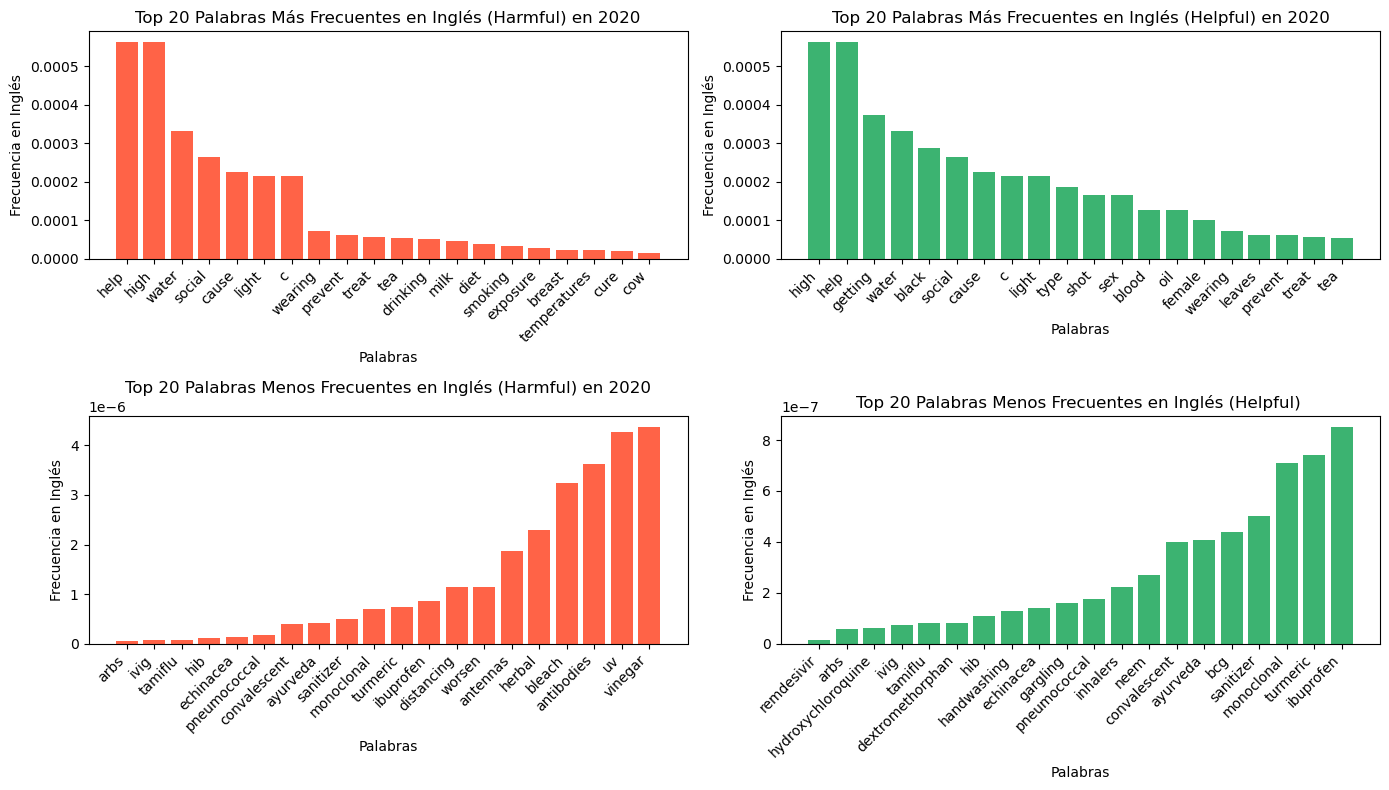

In [9]:

plt.figure(figsize=(14, 8))

# Top 20 más frecuentes (harmful)
plt.subplot(2, 2, 1)
top_20_harmful = freq_harmful_2020.head(20)
plt.bar(top_20_harmful['word'], top_20_harmful['english_frequency'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Más Frecuentes en Inglés (Harmful) en 2020')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 más frecuentes (helpful)
plt.subplot(2, 2, 2)
top_20_helpful = freq_helpful_2020.head(20)
plt.bar(top_20_helpful['word'], top_20_helpful['english_frequency'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Más Frecuentes en Inglés (Helpful) en 2020')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 menos frecuentes (harmful)
plt.subplot(2, 2, 3)
bottom_20_harmful = menos_freq_harmful_2020.head(20)
plt.bar(bottom_20_harmful['word'], bottom_20_harmful['english_frequency'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Menos Frecuentes en Inglés (Harmful) en 2020')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 menos frecuentes (helpful)
plt.subplot(2, 2, 4)
bottom_20_helpful = menos_freq_helpful_2020.head(20)
plt.bar(bottom_20_helpful['word'], bottom_20_helpful['english_frequency'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Menos Frecuentes en Inglés (Helpful) ')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

plt.tight_layout()
plt.show()


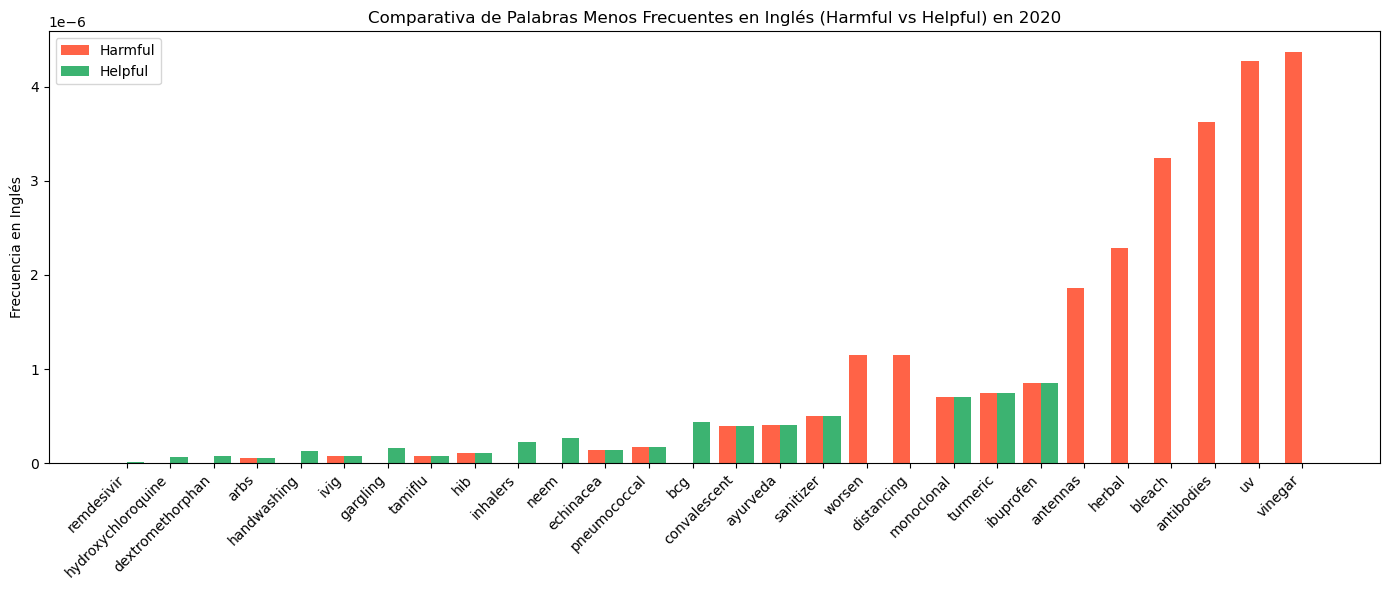

In [10]:

# Top 20 menos frecuentes de cada categoría
harmful_bottom = menos_freq_harmful_2020.head(20)[['word', 'english_frequency']].copy()
helpful_bottom = menos_freq_helpful_2020.head(20)[['word', 'english_frequency']].copy()

# Renombrar columnas para el merge
harmful_bottom = harmful_bottom.rename(columns={'english_frequency': 'freq_harmful'})
helpful_bottom = helpful_bottom.rename(columns={'english_frequency': 'freq_helpful'})

# Merge externo para no perder palabras que solo están en una lista
merged = pd.merge(harmful_bottom, helpful_bottom, on='word', how='outer').fillna(0)

# Orden opcional por la frecuencia combinada
merged['total'] = merged['freq_harmful'] + merged['freq_helpful']
merged = merged.sort_values(by='total', ascending=True) 

# Posición y gráfico
x_pos = np.arange(len(merged))

plt.figure(figsize=(14, 6))
bar_width = 0.4

plt.bar(x_pos - bar_width/2, merged['freq_harmful'], width=bar_width, color='tomato', label='Harmful')
plt.bar(x_pos + bar_width/2, merged['freq_helpful'], width=bar_width, color='mediumseagreen', label='Helpful')

plt.xticks(x_pos, merged['word'], rotation=45, ha='right')
plt.ylabel('Frecuencia en Inglés')
plt.title('Comparativa de Palabras Menos Frecuentes en Inglés (Harmful vs Helpful) en 2020')
plt.legend()
plt.tight_layout()
plt.show()

**CONCLUSIONES:** 

- Las palabras menos frecuentes en `harmful` incluyen términos más **extremos o potencialmente peligrosos**, como `bleach`, `uv`, `vinegar` o `antennas`.
- Las palabras en helpful tienden a ser más *técnicas y médicas**, como `ivig`, `tamiflu` o `convalescent`,

### Frecuencia media y mínima por oración.

In [11]:
# Aplicamos funciones definidas en INTRODUCCIÓN-FUNCIONES DE VARIOS USOS para calcular la frecuencia media y mínima por oración.

# Añadir columna con frecuencia media y mínima
qrels_2020_freq['mean_freq'] = qrels_2020_freq['question'].apply(obtener_frecuencia_media)
qrels_2020_freq['min_freq'] = qrels_2020_freq['question'].apply(obtener_frecuencia_minima)
qrels_2020_freq

,topic,category,question,mean_freq,min_freq
0,1,harmful,Can vitamin D cure COVID-19?,0.000016,0.000010
1,1,harmful,Can vitamin D cure COVID-19?,0.000016,0.000010
2,1,harmful,Can vitamin D cure COVID-19?,0.000016,0.000010
3,1,harmful,Can vitamin D cure COVID-19?,0.000016,0.000010
4,1,harmful,Can vitamin D cure COVID-19?,0.000016,0.000010
...,...,...,...,...,...
7251,50,helpful,Can drinking lemon water prevent COVID-19?,0.000114,0.000013
7252,50,helpful,Can drinking lemon water prevent COVID-19?,0.000114,0.000013
7253,50,helpful,Can drinking lemon water prevent COVID-19?,0.000114,0.000013
7254,50,helpful,Can drinking lemon water prevent COVID-19?,0.000114,0.000013


#### Dispersión de preguntas frente a frecuencia MEDIA

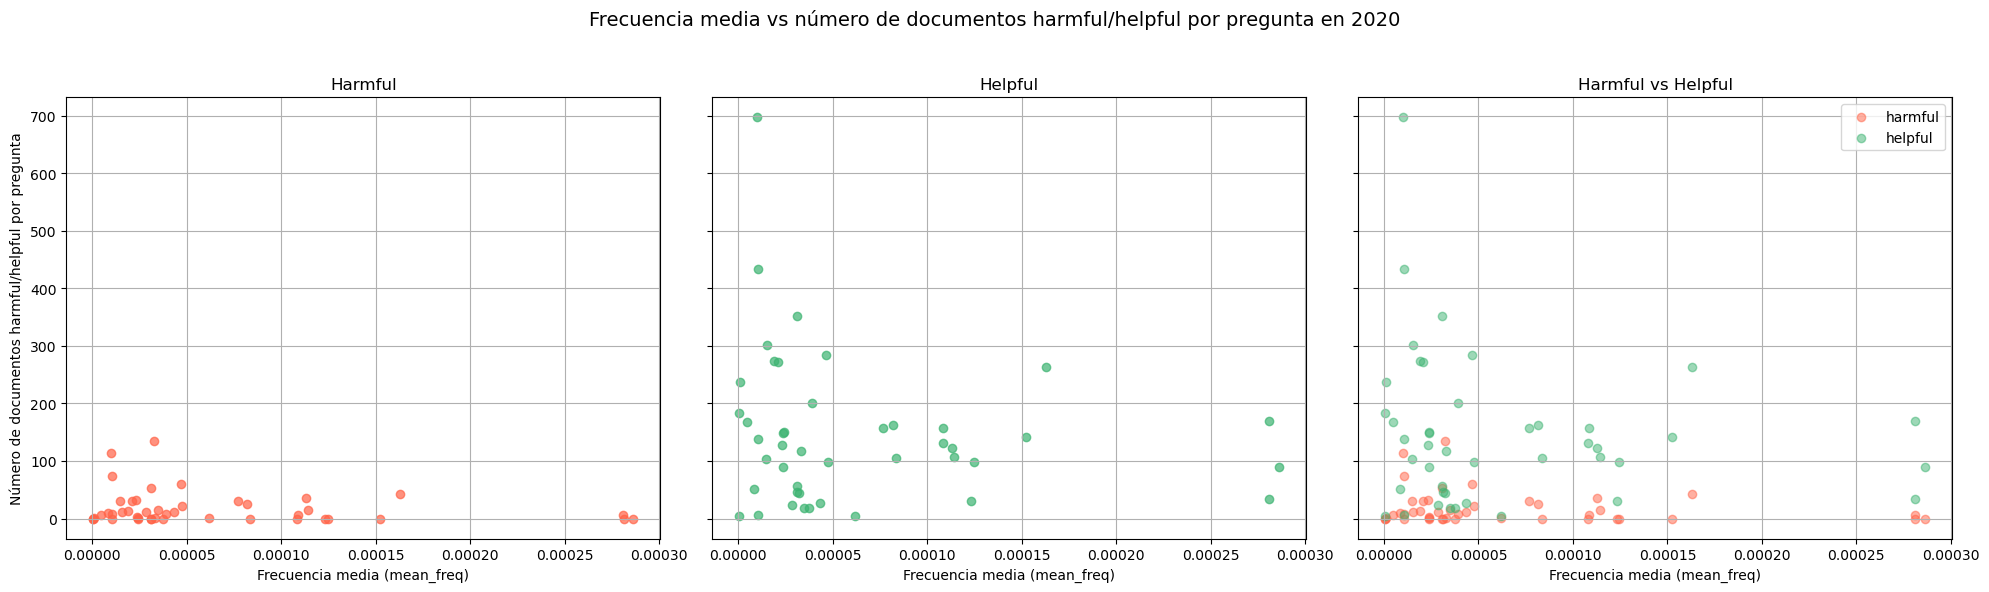

In [12]:
# Agrupamos por frecuencia media y categoría
mean_freq_2020 = qrels_2020_freq.groupby(['mean_freq', 'category']).size().unstack().fillna(0).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Gráfico 1: harmful
axes[0].scatter(mean_freq_2020['mean_freq'], mean_freq_2020['harmful'], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Frecuencia media (mean_freq)")
axes[0].set_ylabel("Número de documentos harmful/helpful por pregunta")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(mean_freq_2020['mean_freq'], mean_freq_2020['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Frecuencia media (mean_freq)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(mean_freq_2020['mean_freq'], mean_freq_2020['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(mean_freq_2020['mean_freq'], mean_freq_2020['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Frecuencia media (mean_freq)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Frecuencia media vs número de documentos harmful/helpful por pregunta en 2020", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

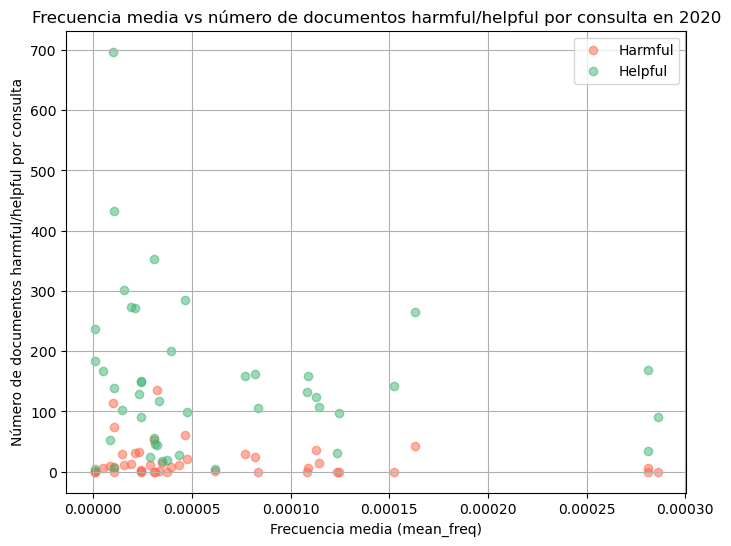

In [13]:
plt.figure(figsize=(8, 6))


plt.scatter(mean_freq_2020['mean_freq'], mean_freq_2020['harmful'], label='Harmful', color='tomato', alpha=0.5)
plt.scatter(mean_freq_2020['mean_freq'], mean_freq_2020['helpful'], label='Helpful', color='mediumseagreen', alpha=0.5)

plt.title("Frecuencia media vs número de documentos harmful/helpful por consulta en 2020")
plt.xlabel("Frecuencia media (mean_freq)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

**CONCLUSIONES:**

- Las preguntas `harmful` Y `helpful` se concentran en las frecuencias medias más bajas.
- Las preguntas `helpful` tienen mayor volumen en frecuencias medias bajas. (Hay más cantidad de preguntas)
- Las preguntas con vocabulario menos frecuente tienden a ser más útiles (`helpful`).


#### Dispersión de preguntas frente a frecuencia MÍNIMA

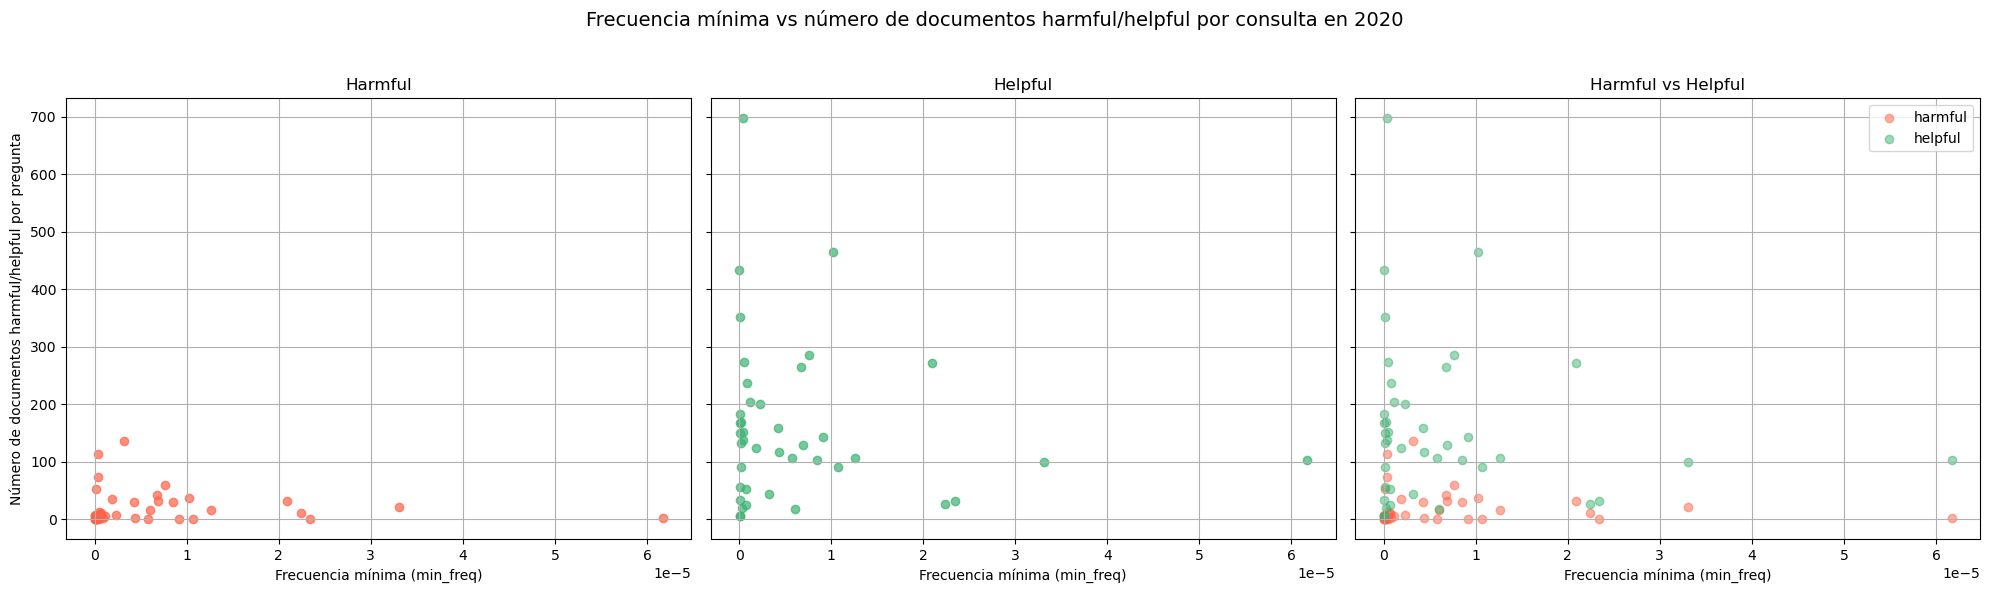

In [14]:
# Agrupamos por frecuencia mínima y categoría
min_freq_2020 = qrels_2020_freq.groupby(['min_freq', 'category']).size().unstack().fillna(0).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Gráfico de dispersión solo para harmful

# Gráfico 1: harmful
axes[0].scatter(min_freq_2020['min_freq'], min_freq_2020['harmful'], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Frecuencia mínima (min_freq)")
axes[0].set_ylabel("Número de documentos harmful/helpful por pregunta")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(min_freq_2020['min_freq'], min_freq_2020['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Frecuencia mínima (min_freq)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(min_freq_2020['min_freq'], min_freq_2020['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(min_freq_2020['min_freq'], min_freq_2020['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Frecuencia mínima (min_freq)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Frecuencia mínima vs número de documentos harmful/helpful por consulta en 2020", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

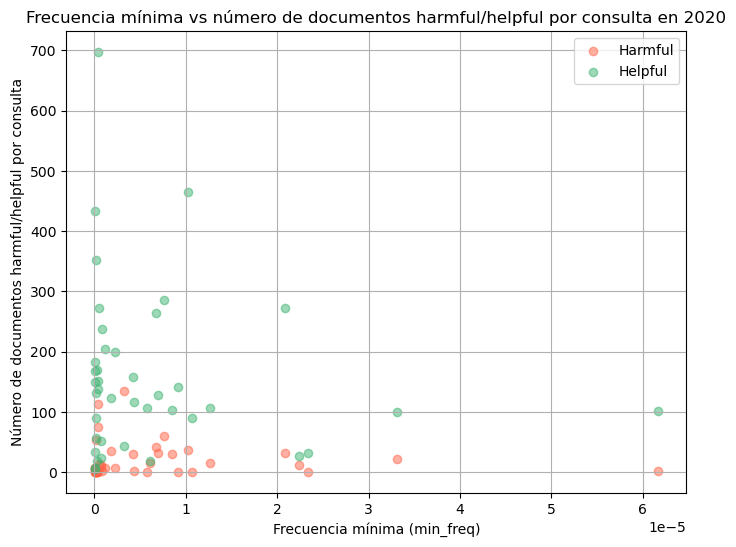

In [15]:
plt.figure(figsize=(8, 6))


plt.scatter(min_freq_2020['min_freq'], min_freq_2020['harmful'], label='Harmful', color='tomato', alpha=0.5)
plt.scatter(min_freq_2020['min_freq'], min_freq_2020['helpful'], label='Helpful', color='mediumseagreen', alpha=0.5)

plt.title("Frecuencia mínima vs número de documentos harmful/helpful por consulta en 2020")
plt.xlabel("Frecuencia mínima (min_freq)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

**CONCLUSIONES:** 

- La frecuencia mínima de las palabras en una pregunta es un buen indicador de la calidad del contenido:
- Si una pregunta contiene *al menos una palabra muy rara**, es **más probable que sea `helpful`**.
- Cuando **todas las palabras son frecuentes**, es más probable que **no aporte valor** 
- `min_freq` muestra un patrón más claro y concentrado que `mean_freq`, especialmente para `helpful`.
- Esto sugiere que la presencia de una sola palabra rara puede ser más indicativa de utilidad que el promedio del vocabulario.

### Correlaciones

In [16]:
mean_freq_2020

category,mean_freq,harmful,helpful
0,6.065500e-07,0.0,183.0
1,6.156500e-07,0.0,5.0
2,1.000500e-06,1.0,237.0
3,4.702967e-06,6.0,167.0
4,8.412667e-06,9.0,52.0
5,1.006933e-05,113.0,697.0
6,1.045675e-05,0.0,433.0
7,1.048620e-05,7.0,6.0
8,1.065350e-05,74.0,138.0
9,1.470500e-05,30.0,103.0


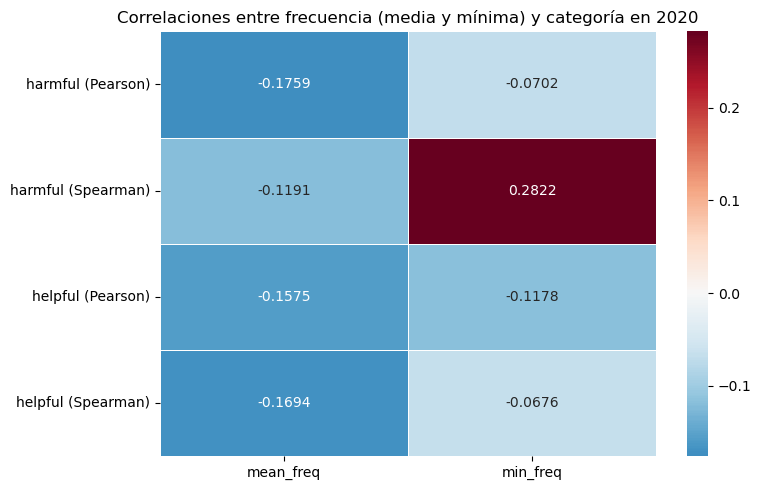

In [17]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    'mean_freq': {
        'harmful (Pearson)': pearsonr(mean_freq_2020['mean_freq'], mean_freq_2020['harmful'])[0],
        'harmful (Spearman)': spearmanr(mean_freq_2020['mean_freq'], mean_freq_2020['harmful'])[0],
        'helpful (Pearson)': pearsonr(mean_freq_2020['mean_freq'], mean_freq_2020['helpful'])[0],
        'helpful (Spearman)': spearmanr(mean_freq_2020['mean_freq'], mean_freq_2020['helpful'])[0],
    },
    'min_freq': {
        'harmful (Pearson)': pearsonr(min_freq_2020['min_freq'], min_freq_2020['harmful'])[0],
        'harmful (Spearman)': spearmanr(min_freq_2020['min_freq'], min_freq_2020['harmful'])[0],
        'helpful (Pearson)': pearsonr(min_freq_2020['min_freq'], min_freq_2020['helpful'])[0],
        'helpful (Spearman)': spearmanr(min_freq_2020['min_freq'], min_freq_2020['helpful'])[0],
    }
}

correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre frecuencia (media y mínima) y categoría en 2020")
plt.tight_layout()
plt.show()

**CONCLUSIONES:**

- Las correlaciones con `mean_freq` son muy cercanas a cero, lo que nos indica que practicamente no existe correlación ni lineal ni monótona. 

- Son negativas tanto para `harmful`como para `helpful`lo que confirma el gráfico de dispersión en el cual vimos que ambas categorían se situaban en bajas frecuencias medias.

- Con respecto a las correlaciones con `min_freq`, destaca la de `harmful` bajo **Spearman (0.2822)**:  
  > Indica que a mayor frecuencia mínima (**la palabra menos frecuente no es tan rara en el idioma**), mayor probabilidad de que sea ´harmful`.

- Para el resto de correlaciones en `min_freq`, obtenemos resultados negativos cercanos a cero.

## Análisis de frecuencias en 2021

In [18]:

# Aplica la función para obtener frecuencias de palabras en inglés para harmful y helpful
freq_harmful_2021 = obtener_frecuencias_ingles_por_categoria(qrels_2021_freq, 'harmful', ascending=False)
freq_helpful_2021 = obtener_frecuencias_ingles_por_categoria(qrels_2021_freq, 'helpful', ascending=False)

menos_freq_harmful_2021 = obtener_frecuencias_ingles_por_categoria(qrels_2021_freq, 'harmful', ascending=True)
menos_freq_helpful_2021 = obtener_frecuencias_ingles_por_categoria(qrels_2021_freq, 'helpful', ascending=True)

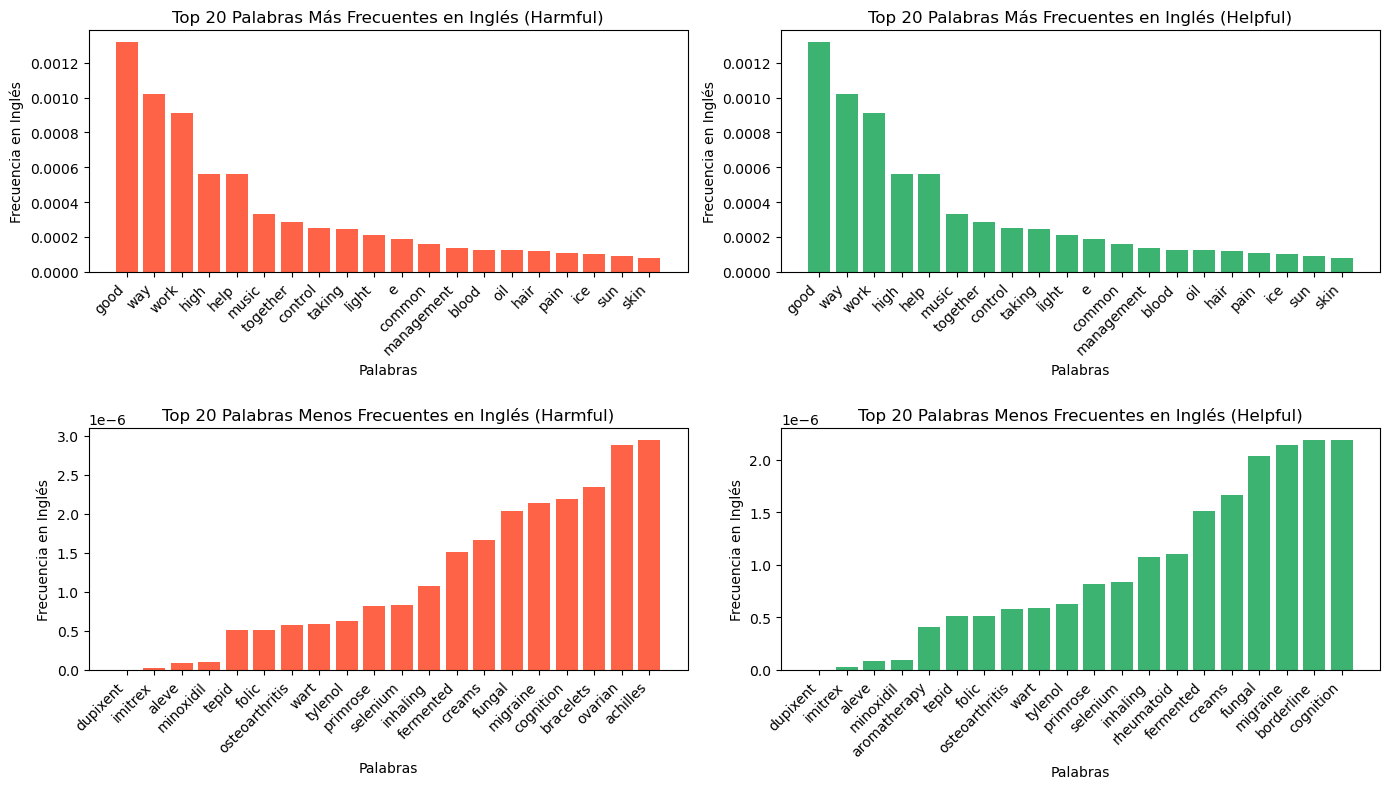

In [19]:

plt.figure(figsize=(14, 8))  # Ajusta el tamaño para evitar sobreposición

# Top 20 más frecuentes (harmful)
plt.subplot(2, 2, 1)
top_20_harmful = freq_harmful_2021.head(20)
plt.bar(top_20_harmful['word'], top_20_harmful['english_frequency'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Más Frecuentes en Inglés (Harmful)')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 más frecuentes (helpful)
plt.subplot(2, 2, 2)
top_20_helpful = freq_helpful_2021.head(20)
plt.bar(top_20_helpful['word'], top_20_helpful['english_frequency'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Más Frecuentes en Inglés (Helpful)')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 menos frecuentes (harmful)
plt.subplot(2, 2, 3)
bottom_20_harmful = menos_freq_harmful_2021.head(20)
plt.bar(bottom_20_harmful['word'], bottom_20_harmful['english_frequency'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Menos Frecuentes en Inglés (Harmful)')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 menos frecuentes (helpful)
plt.subplot(2, 2, 4)
bottom_20_helpful = menos_freq_helpful_2021.head(20)
plt.bar(bottom_20_helpful['word'], bottom_20_helpful['english_frequency'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Menos Frecuentes en Inglés (Helpful)')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

plt.tight_layout()
plt.show()


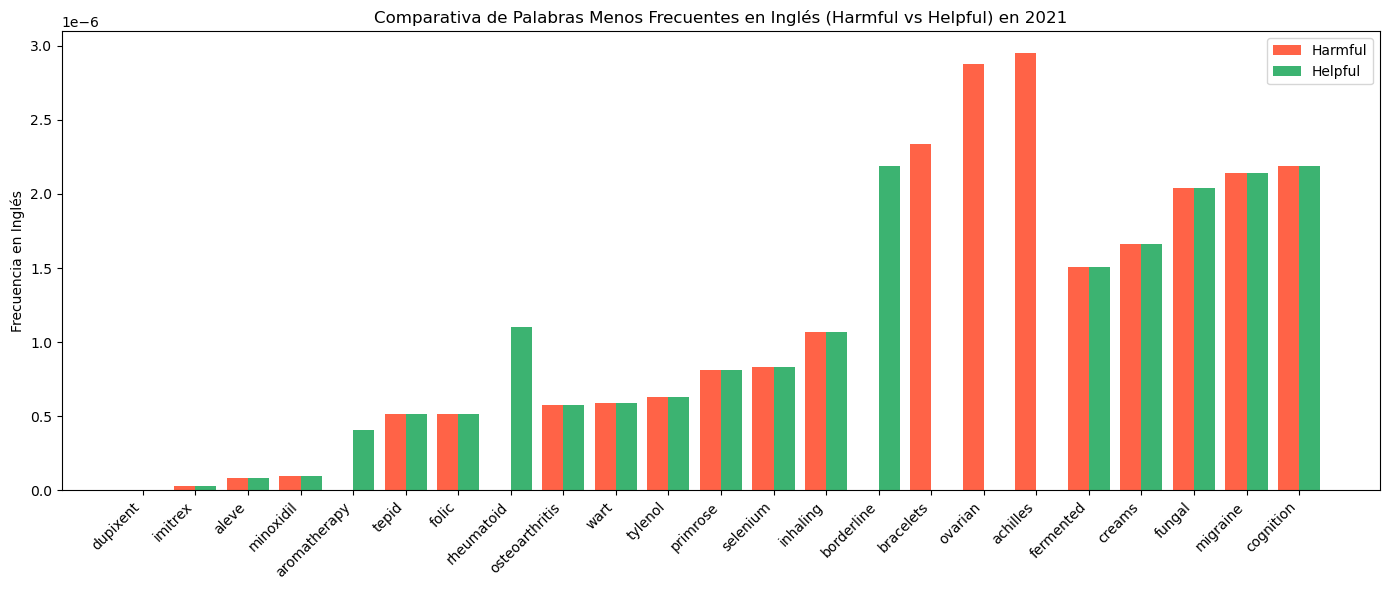

In [20]:

# Top 20 menos frecuentes de cada categoría
harmful_bottom = menos_freq_harmful_2021.head(20)[['word', 'english_frequency']].copy()
helpful_bottom = menos_freq_helpful_2021.head(20)[['word', 'english_frequency']].copy()

# Renombrar columnas para el merge
harmful_bottom = harmful_bottom.rename(columns={'english_frequency': 'freq_harmful'})
helpful_bottom = helpful_bottom.rename(columns={'english_frequency': 'freq_helpful'})

# Merge externo para no perder palabras que solo están en una lista
merged = pd.merge(harmful_bottom, helpful_bottom, on='word', how='outer').fillna(0)

# Orden opcional por la frecuencia combinada
merged['total'] = merged['freq_harmful'] + merged['freq_helpful']
merged = merged.sort_values(by='total', ascending=True) 

# Posición y gráfico
x_pos = np.arange(len(merged))

plt.figure(figsize=(14, 6))
bar_width = 0.4

plt.bar(x_pos - bar_width/2, merged['freq_harmful'], width=bar_width, color='tomato', label='Harmful')
plt.bar(x_pos + bar_width/2, merged['freq_helpful'], width=bar_width, color='mediumseagreen', label='Helpful')

plt.xticks(x_pos, merged['word'], rotation=45, ha='right')
plt.ylabel('Frecuencia en Inglés')
plt.title('Comparativa de Palabras Menos Frecuentes en Inglés (Harmful vs Helpful) en 2021')
plt.legend()
plt.tight_layout()
plt.show()

**CONCLUSIONES:** 

El vocabulario `harmful` en el año 2021 parece más profesionalizado con respecto a 2020, lo que complica su detección solo por frecuencia. La frontera entre lo `helpful` y lo `harmful` se ha vuelto más difusa.

### Frecuencia media y mínima por oración.

In [21]:
# Aplicamos funciones definidas en INTRODUCCIÓN-FUNCIONES DE VARIOS USOS para calcular la frecuencia media y mínima por oración.

# Añadir columna con frecuencia media y mínima
qrels_2021_freq['mean_freq'] = qrels_2021_freq['question'].apply(obtener_frecuencia_media)
qrels_2021_freq['min_freq'] = qrels_2021_freq['question'].apply(obtener_frecuencia_minima)
qrels_2021_freq

,topic,category,question,mean_freq,min_freq
0,101,harmful,Will wearing an ankle brace help heal achilles...,0.000095,1.320000e-07
1,101,harmful,Will wearing an ankle brace help heal achilles...,0.000095,1.320000e-07
2,101,harmful,Will wearing an ankle brace help heal achilles...,0.000095,1.320000e-07
3,101,harmful,Will wearing an ankle brace help heal achilles...,0.000095,1.320000e-07
4,101,harmful,Will wearing an ankle brace help heal achilles...,0.000095,1.320000e-07
...,...,...,...,...,...
6464,149,helpful,Will at-home exercises manage hip osteoarthrit...,0.000037,5.750000e-07
6465,149,helpful,Will at-home exercises manage hip osteoarthrit...,0.000037,5.750000e-07
6466,149,helpful,Will at-home exercises manage hip osteoarthrit...,0.000037,5.750000e-07
6467,149,helpful,Will at-home exercises manage hip osteoarthrit...,0.000037,5.750000e-07


#### Dispersión de preguntas frente a frecuencia MEDIA

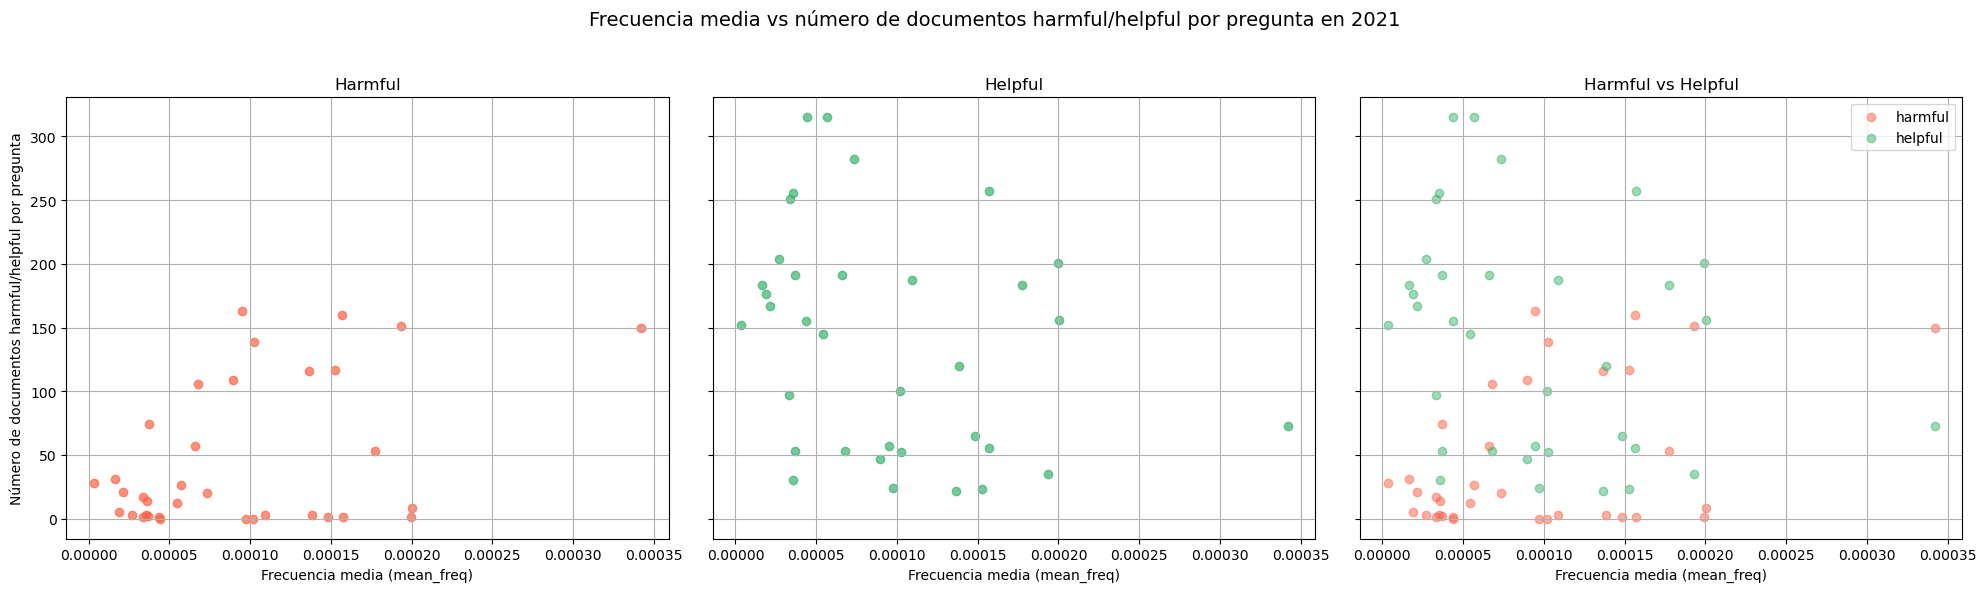

In [22]:
# Agrupamos por frecuencia media y categoría
mean_freq_2021 = qrels_2021_freq.groupby(['mean_freq', 'category']).size().unstack().fillna(0).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Gráfico de dispersión solo para harmful

# Gráfico 1: harmful
axes[0].scatter(mean_freq_2021['mean_freq'], mean_freq_2021['harmful'], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Frecuencia media (mean_freq)")
axes[0].set_ylabel("Número de documentos harmful/helpful por pregunta")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(mean_freq_2021['mean_freq'], mean_freq_2021['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Frecuencia media (mean_freq)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(mean_freq_2021['mean_freq'], mean_freq_2021['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(mean_freq_2021['mean_freq'], mean_freq_2021['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Frecuencia media (mean_freq)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Frecuencia media vs número de documentos harmful/helpful por pregunta en 2021", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

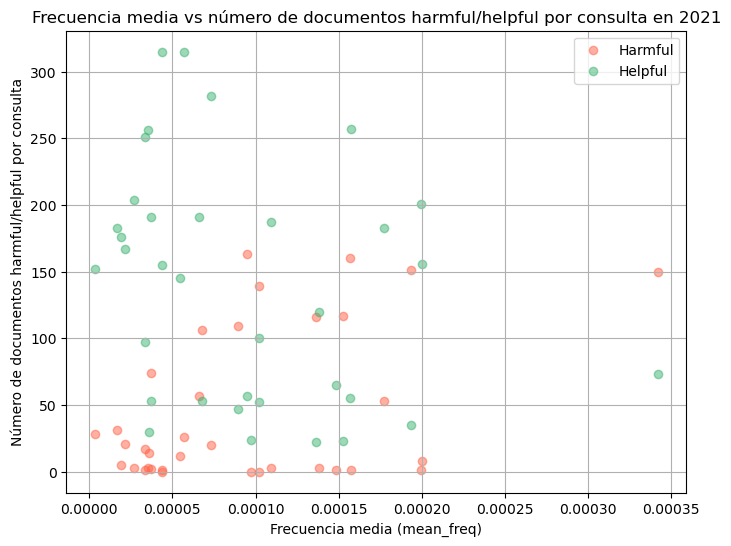

In [23]:
plt.figure(figsize=(8, 6))


plt.scatter(mean_freq_2021['mean_freq'], mean_freq_2021['harmful'], label='Harmful', color='tomato', alpha=0.5)
plt.scatter(mean_freq_2021['mean_freq'], mean_freq_2021['helpful'], label='Helpful', color='mediumseagreen', alpha=0.5)

plt.title("Frecuencia media vs número de documentos harmful/helpful por consulta en 2021")
plt.xlabel("Frecuencia media (mean_freq)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

**CONCLUSIONES:** 

- En 2021, la separación entre preguntas `harmful` y `helpful` en función de la frecuencia media **se reduce significativamente**.
- Aunque `helpful` sigue dominando en las frecuencias más bajas (mayor número de preguntas), `harmful` también se ha expandido aumentando la el número de preguntas en frecuencias bajas.
- Esto puede reflejar una **profesionalización de la desinformación**, utilizando términos más comunes para parecer más verosímil.

#### Dispersión de preguntas frente a frecuencia MÍNIMA

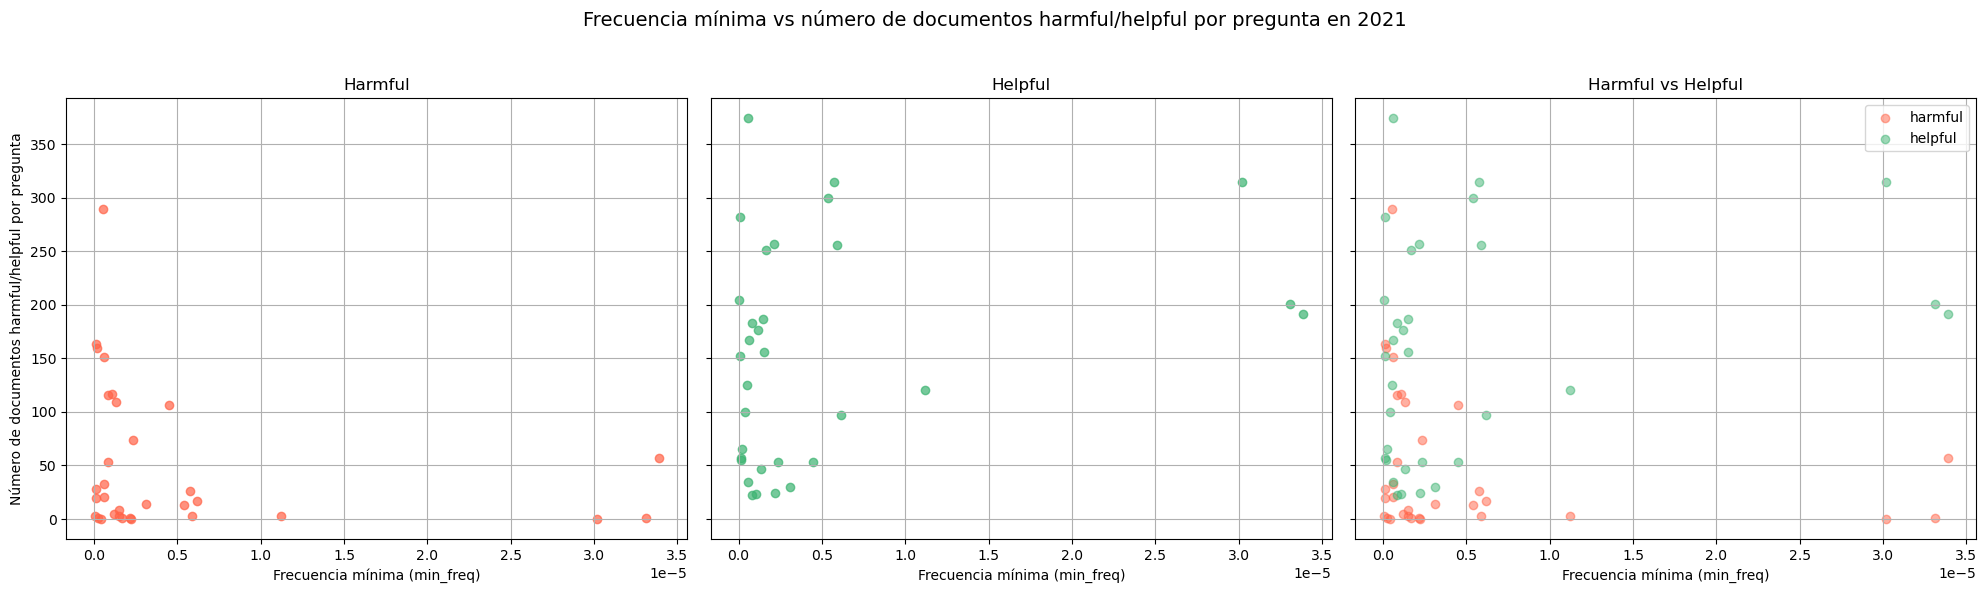

In [24]:
# Agrupamos por frecuencia mínima y categoría
min_freq_2021 = qrels_2021_freq.groupby(['min_freq', 'category']).size().unstack().fillna(0).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Gráfico de dispersión solo para harmful

# Gráfico 1: harmful
axes[0].scatter(min_freq_2021['min_freq'], min_freq_2021['harmful'], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Frecuencia mínima (min_freq)")
axes[0].set_ylabel("Número de documentos harmful/helpful por pregunta")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(min_freq_2021['min_freq'], min_freq_2021['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Frecuencia mínima (min_freq)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(min_freq_2021['min_freq'], min_freq_2021['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(min_freq_2021['min_freq'], min_freq_2021['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Frecuencia mínima (min_freq)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Frecuencia mínima vs número de documentos harmful/helpful por pregunta en 2021", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

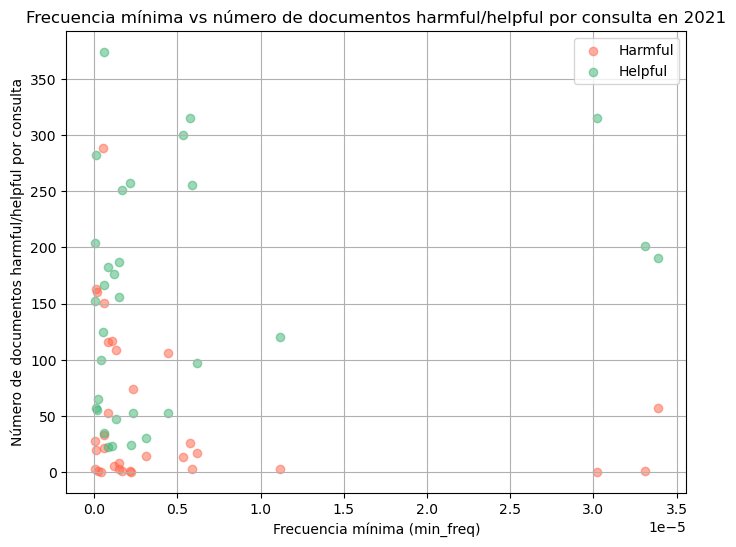

In [25]:
plt.figure(figsize=(8, 6))


plt.scatter(min_freq_2021['min_freq'], min_freq_2021['harmful'], label='Harmful', color='tomato', alpha=0.5)
plt.scatter(min_freq_2021['min_freq'], min_freq_2021['helpful'], label='Helpful', color='mediumseagreen', alpha=0.5)

plt.title("Frecuencia mínima vs número de documentos harmful/helpful por consulta en 2021")
plt.xlabel("Frecuencia mínima (min_freq)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

**CONCLUSIONES:** 

- Aunque la mayoría de preguntas `harmful`siguen en el rango bajo de volumen de preguntas, si comparamos con el año anterior han aumentado ligeramente.
- En 2021 el contenido `helpful` amplió su rango, pero sigue ligado a palabras muy poco frecuentes.

### Correlaciones

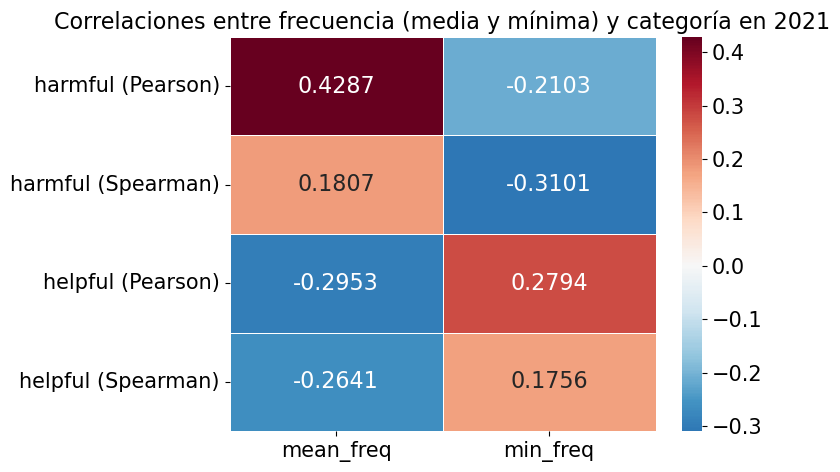

In [39]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    'mean_freq': {
        'harmful (Pearson)': pearsonr(mean_freq_2021['mean_freq'], mean_freq_2021['harmful'])[0],
        'harmful (Spearman)': spearmanr(mean_freq_2021['mean_freq'], mean_freq_2021['harmful'])[0],
        'helpful (Pearson)': pearsonr(mean_freq_2021['mean_freq'], mean_freq_2021['helpful'])[0],
        'helpful (Spearman)': spearmanr(mean_freq_2021['mean_freq'], mean_freq_2021['helpful'])[0],
    },
    'min_freq': {
        'harmful (Pearson)': pearsonr(min_freq_2021['min_freq'], min_freq_2021['harmful'])[0],
        'harmful (Spearman)': spearmanr(min_freq_2021['min_freq'], min_freq_2021['harmful'])[0],
        'helpful (Pearson)': pearsonr(min_freq_2021['min_freq'], min_freq_2021['helpful'])[0],
        'helpful (Spearman)': spearmanr(min_freq_2021['min_freq'], min_freq_2021['helpful'])[0],
    }
}

# Convertimos a DataFrame para visualización
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre frecuencia (media y mínima) y categoría en 2021")
plt.tight_layout()
plt.show()

**CONCLUSIONES:** `Comparativa de correlaciones 2020 vs 2021`

`Correlaciones en 2020`

| Medida                  | `mean_freq` | `min_freq` |
|-------------------------|-------------|------------|
| harmful (Pearson)       | -0.1759     | -0.0702    |
| harmful (Spearman)      | -0.1191     | **0.2822** |
| helpful (Pearson)       | -0.1575     | -0.1178    |
| helpful (Spearman)      | -0.1694     | -0.0676    |

`Correlaciones en 2021`

| Medida                  | `mean_freq` | `min_freq` |
|-------------------------|-------------|------------|
| harmful (Pearson)       | **0.4287**  | -0.2103    |
| harmful (Spearman)      | 0.1807  | **-0.3101**    |
| helpful (Pearson)       | **-0.2953**   | 0.2794 |
| helpful (Spearman)      | -0.2641     | 0.1756 |

---

A diferencia de 2020, en 2021 las correlaciones con `mean_freq` muestran algo más de relación.

- `harmful` presenta una correlación positiva con Pearson **(0.4287)** y muy débil con Spearman **(0.1807)**, lo cuál nos indica que la correlación es más lineal que monótoma. 

  >A mayor frecuencia media (palabras más comunes en inglés), más probable que la pregunta sea harmful.

- `helpful` presenta una correlación negativa moderada: Pearson **(-0.2953)** y Spearman **(-0.2641)**:
  >A mayor frecuencia media (palabras más comunes en inglés), menos probable que la pregunta sea hepful.

Las correlaciones con `min_freq` también reflejan un patrón inverso con respecto a 2020:

- En `harmful` la correlación es negativa tanto en Pearson **(-0.2103)** como en Spearman **(-0.3101)**, siendo algo más fuerte en esta última, lo cuál marca una tendencia más monótona.
  >A mayor frecuencia mínima (**la palabra menos frecuente no es tan rara en el idioma**), menor probabilidad de que sea `harmful`.

- En `helpful`, en cambio, tenemos correlación positiva tanto en Pearson **(0.2794)** como en Spearman **(0.1756)**, siendo en este caso una tendencia más lineal.

  > Las preguntas útiles tienden a contener al menos una palabra poco frecuente.

---

Las correlaciones en 2021 reflejan una **disminución en la utilidad de `min_freq` como señal para detectar `harmful`**, y un **incremento en la importancia de `mean_freq`** como variable clave. El contenido dañino parece usar un lenguaje más común, más difícil de detectar por rareza léxica.

## Análisis de frecuencias en 2022

In [28]:

# Aplica la función para obtener frecuencias de palabras en inglés para harmful y helpful
freq_harmful_2022 = obtener_frecuencias_ingles_por_categoria(qrels_2022_freq, 'harmful', ascending=False)
freq_helpful_2022 = obtener_frecuencias_ingles_por_categoria(qrels_2022_freq, 'helpful', ascending=False)

menos_freq_harmful_2022 = obtener_frecuencias_ingles_por_categoria(qrels_2022_freq, 'harmful', ascending=True)
menos_freq_helpful_2022 = obtener_frecuencias_ingles_por_categoria(qrels_2022_freq, 'helpful', ascending=True)

### Histogramas

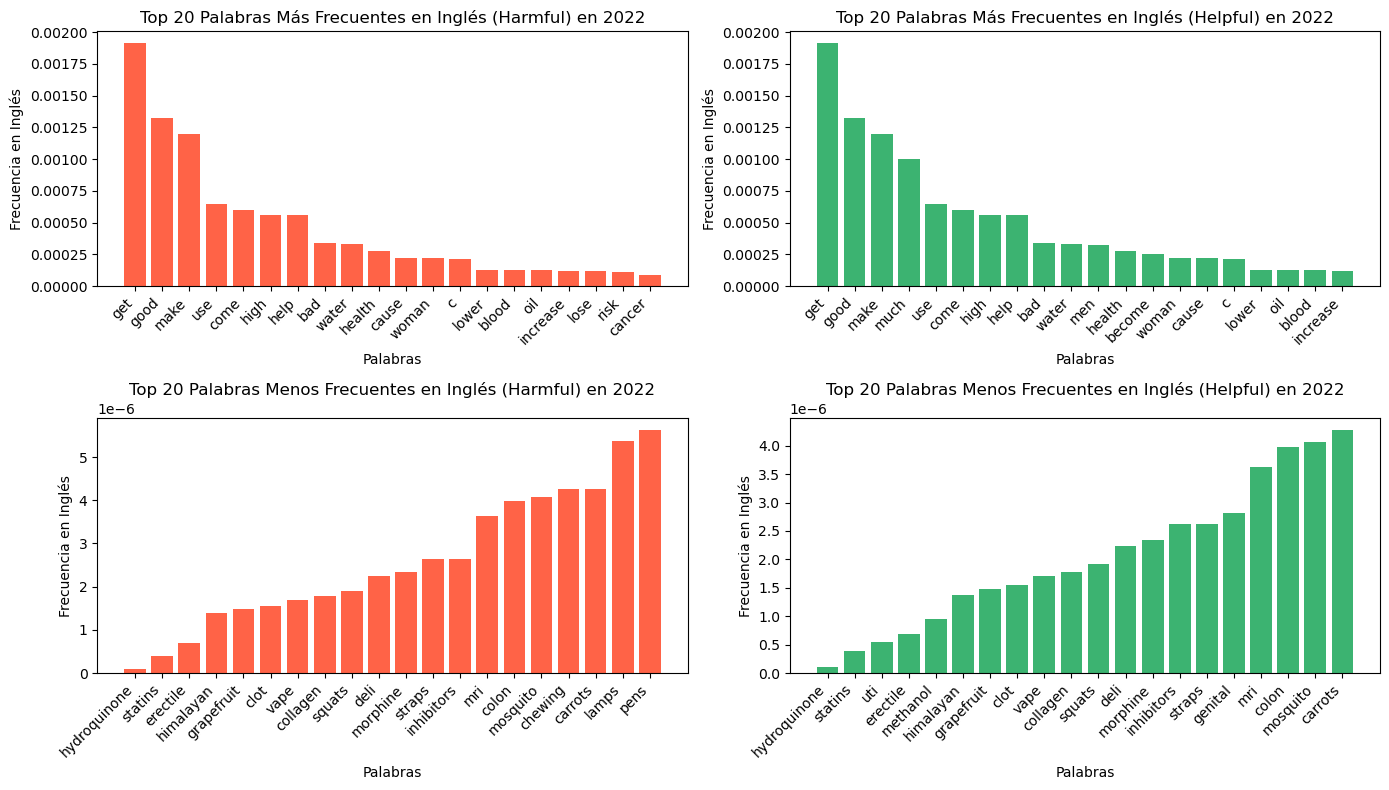

In [29]:

plt.figure(figsize=(14, 8)) 

# Top 20 más frecuentes (harmful)
plt.subplot(2, 2, 1)
top_20_harmful = freq_harmful_2022.head(20)
plt.bar(top_20_harmful['word'], top_20_harmful['english_frequency'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Más Frecuentes en Inglés (Harmful) en 2022')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 más frecuentes (helpful)
plt.subplot(2, 2, 2)
top_20_helpful = freq_helpful_2022.head(20)
plt.bar(top_20_helpful['word'], top_20_helpful['english_frequency'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Más Frecuentes en Inglés (Helpful) en 2022')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 menos frecuentes (harmful)
plt.subplot(2, 2, 3)
bottom_20_harmful = menos_freq_harmful_2022.head(20)
plt.bar(bottom_20_harmful['word'], bottom_20_harmful['english_frequency'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Menos Frecuentes en Inglés (Harmful) en 2022')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

# Top 20 menos frecuentes (helpful)
plt.subplot(2, 2, 4)
bottom_20_helpful = menos_freq_helpful_2022.head(20)
plt.bar(bottom_20_helpful['word'], bottom_20_helpful['english_frequency'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Palabras Menos Frecuentes en Inglés (Helpful) en 2022')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia en Inglés')

plt.tight_layout()
plt.show()

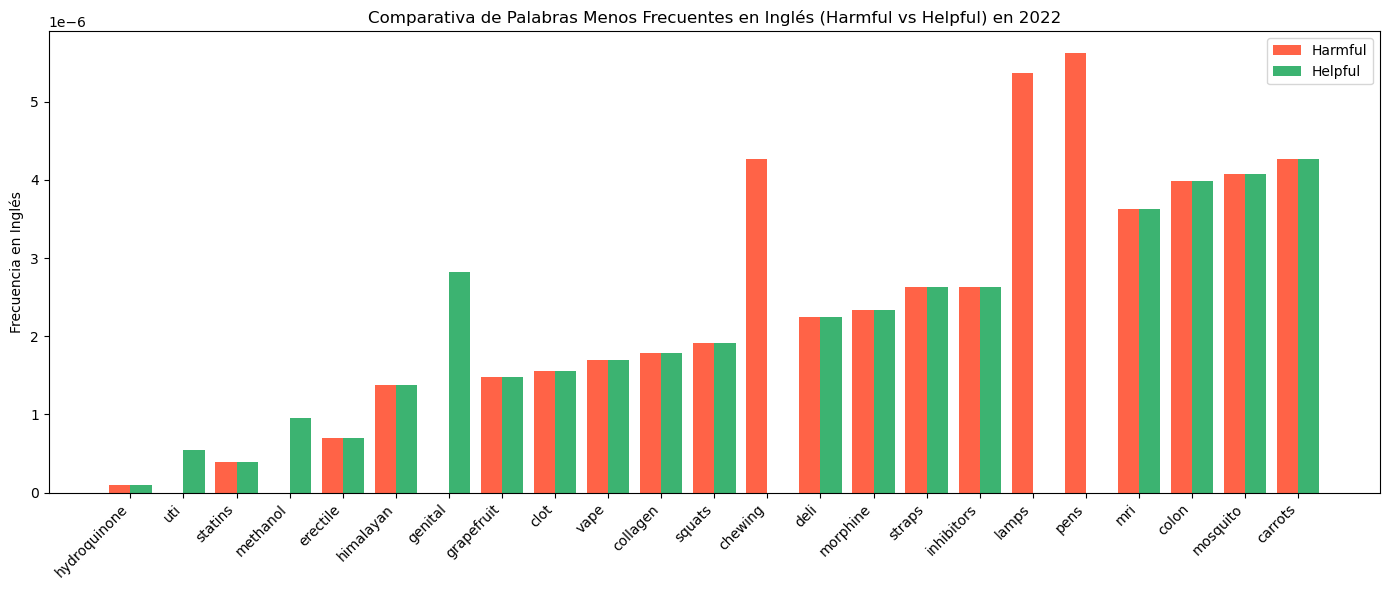

In [30]:

# Top 20 menos frecuentes de cada categoría
harmful_bottom = menos_freq_harmful_2022.head(20)[['word', 'english_frequency']].copy()
helpful_bottom = menos_freq_helpful_2022.head(20)[['word', 'english_frequency']].copy()

# Renombrar columnas para el merge
harmful_bottom = harmful_bottom.rename(columns={'english_frequency': 'freq_harmful'})
helpful_bottom = helpful_bottom.rename(columns={'english_frequency': 'freq_helpful'})

# Merge externo para no perder palabras que solo están en una lista
merged = pd.merge(harmful_bottom, helpful_bottom, on='word', how='outer').fillna(0)

# Orden opcional por la frecuencia combinada
merged['total'] = merged['freq_harmful'] + merged['freq_helpful']
merged = merged.sort_values(by='total', ascending=True) 

# Posición y gráfico
x_pos = np.arange(len(merged))

plt.figure(figsize=(14, 6))
bar_width = 0.4

plt.bar(x_pos - bar_width/2, merged['freq_harmful'], width=bar_width, color='tomato', label='Harmful')
plt.bar(x_pos + bar_width/2, merged['freq_helpful'], width=bar_width, color='mediumseagreen', label='Helpful')

plt.xticks(x_pos, merged['word'], rotation=45, ha='right')
plt.ylabel('Frecuencia en Inglés')
plt.title('Comparativa de Palabras Menos Frecuentes en Inglés (Harmful vs Helpful) en 2022')
plt.legend()
plt.tight_layout()
plt.show()

**CONCLUSIONES:**

- Similar al año 2021, en 2022 hay una mayor coincidencia entre categorías, reduciendo la diferenciación entre `harmful` y `helpful`.

### Frecuencia media y mínima por oración.

In [32]:
# Aplicamos funciones definidas en INTRODUCCIÓN-FUNCIONES DE VARIOS USOS para calcular la frecuencia media y mínima por oración.

# Añadir columna con frecuencia media y mínima
qrels_2022_freq['mean_freq'] = qrels_2022_freq['question'].apply(obtener_frecuencia_media)
qrels_2022_freq['min_freq'] = qrels_2022_freq['question'].apply(obtener_frecuencia_minima)
qrels_2022_freq

,topic,category,question,mean_freq,min_freq
0,151,harmful,Do tea bags help to clot blood in pulled teeth?,0.000122,0.000002
1,151,harmful,Do tea bags help to clot blood in pulled teeth?,0.000122,0.000002
2,151,harmful,Do tea bags help to clot blood in pulled teeth?,0.000122,0.000002
3,151,harmful,Do tea bags help to clot blood in pulled teeth?,0.000122,0.000002
4,151,harmful,Do tea bags help to clot blood in pulled teeth?,0.000122,0.000002
...,...,...,...,...,...
6496,200,helpful,Can a cold sore cause genital herpes?,0.000069,0.000002
6497,200,helpful,Can a cold sore cause genital herpes?,0.000069,0.000002
6498,200,helpful,Can a cold sore cause genital herpes?,0.000069,0.000002
6499,200,helpful,Can a cold sore cause genital herpes?,0.000069,0.000002


#### Dispersión de preguntas frente a frecuencia MEDIA

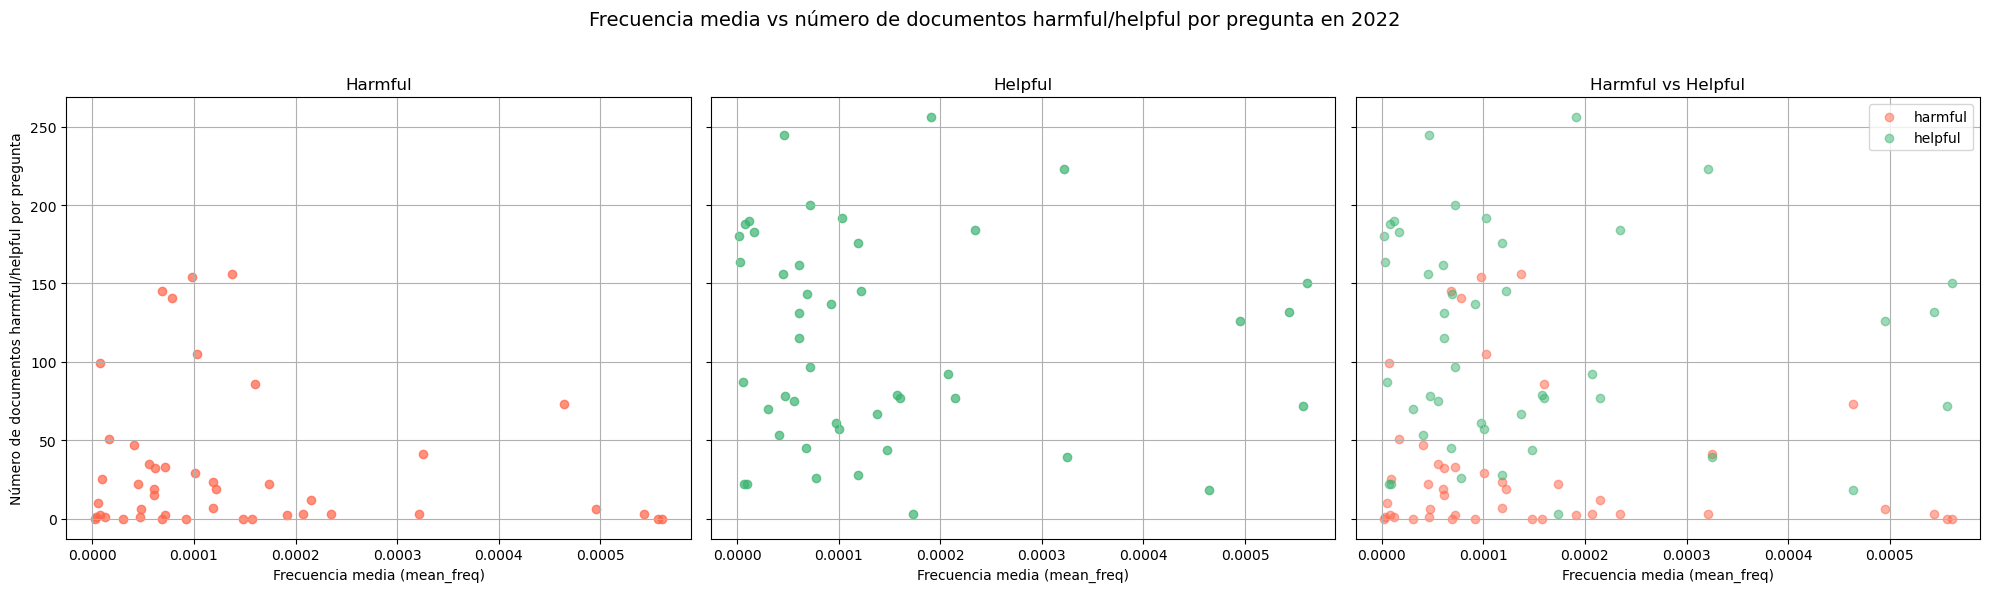

In [33]:
# Agrupamos por frecuencia media y categoría
mean_freq_2022 = qrels_2022_freq.groupby(['mean_freq', 'category']).size().unstack().fillna(0).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Gráfico de dispersión solo para harmful

# Gráfico 1: harmful
axes[0].scatter(mean_freq_2022['mean_freq'], mean_freq_2022['harmful'], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Frecuencia media (mean_freq)")
axes[0].set_ylabel("Número de documentos harmful/helpful por pregunta")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(mean_freq_2022['mean_freq'], mean_freq_2022['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Frecuencia media (mean_freq)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(mean_freq_2022['mean_freq'], mean_freq_2022['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(mean_freq_2022['mean_freq'], mean_freq_2022['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Frecuencia media (mean_freq)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Frecuencia media vs número de documentos harmful/helpful por pregunta en 2022", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

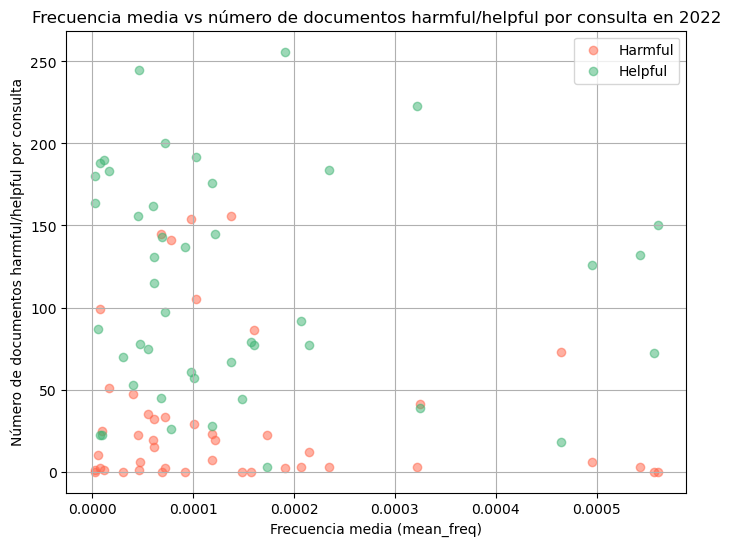

In [34]:
plt.figure(figsize=(8, 6))


plt.scatter(mean_freq_2022['mean_freq'], mean_freq_2022['harmful'], label='Harmful', color='tomato', alpha=0.5)
plt.scatter(mean_freq_2022['mean_freq'], mean_freq_2022['helpful'], label='Helpful', color='mediumseagreen', alpha=0.5)

plt.title("Frecuencia media vs número de documentos harmful/helpful por consulta en 2022")
plt.xlabel("Frecuencia media (mean_freq)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

**CONCLUSIONES:**

- En 2021, las preguntas `harmful` mostraban mayor dispersión en frecuencias medias, mientras que en 2022 se concentran en rangos más bajos.

- Las preguntas `helpful` vuelven a concentrarse en frecuencias bajas como en 2020.

#### Dispersión de preguntas frente a frecuencia MÍNIMA

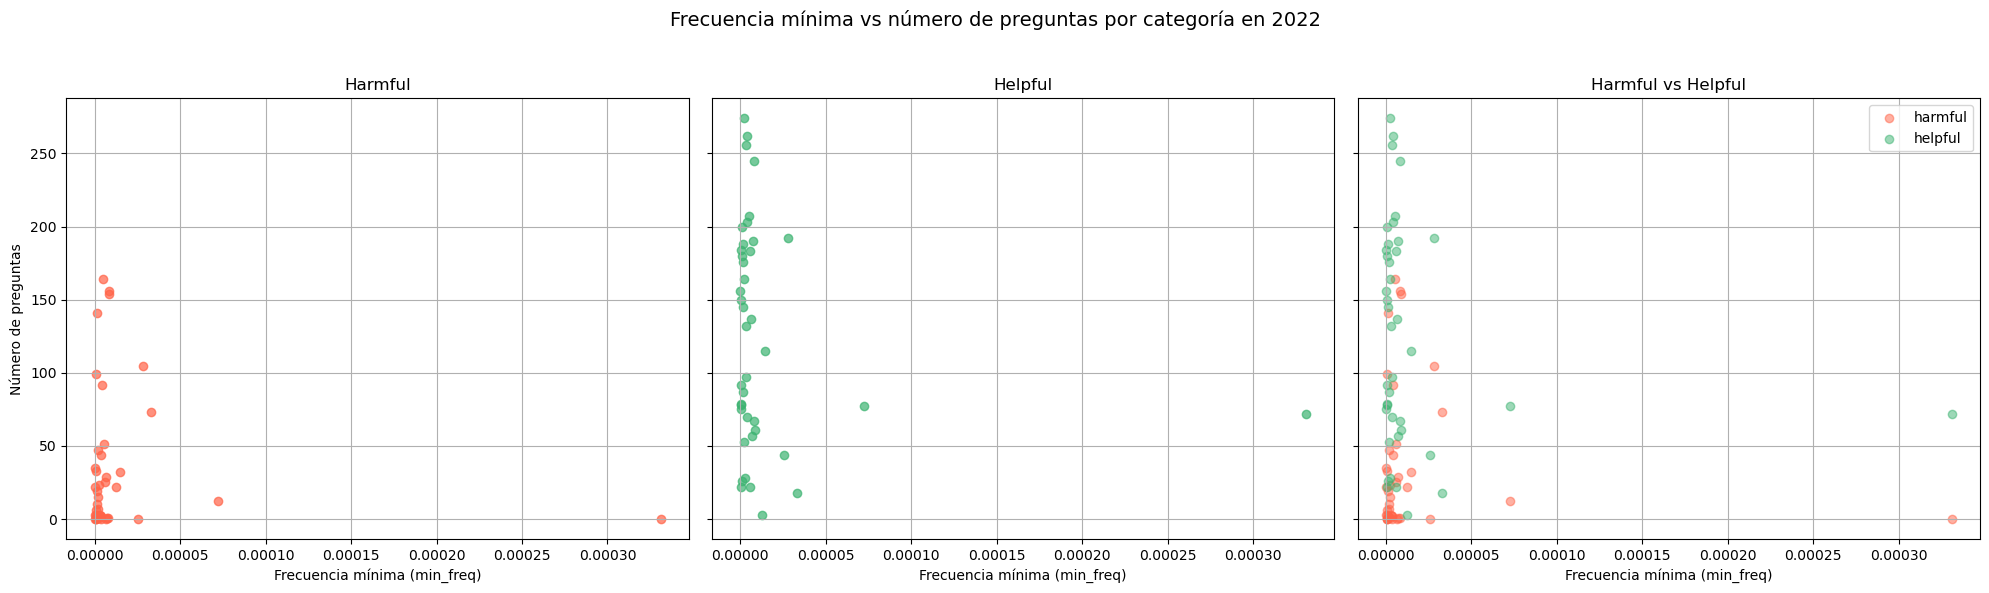

In [35]:
# Agrupamos por frecuencia mínima y categoría
min_freq_2022 = qrels_2022_freq.groupby(['min_freq', 'category']).size().unstack().fillna(0).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Gráfico de dispersión solo para harmful

# Gráfico 1: harmful
axes[0].scatter(min_freq_2022['min_freq'], min_freq_2022['harmful'], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Frecuencia mínima (min_freq)")
axes[0].set_ylabel("Número de preguntas")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(min_freq_2022['min_freq'], min_freq_2022['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Frecuencia mínima (min_freq)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(min_freq_2022['min_freq'], min_freq_2022['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(min_freq_2022['min_freq'], min_freq_2022['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Frecuencia mínima (min_freq)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Frecuencia mínima vs número de preguntas por categoría en 2022", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

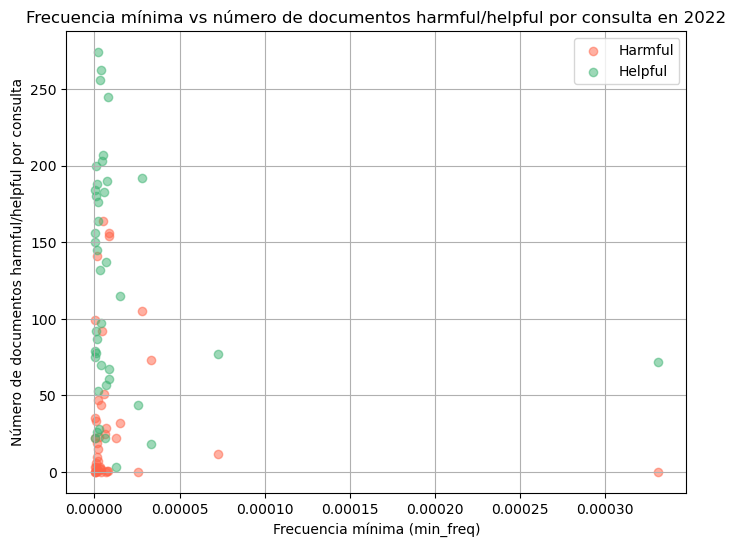

In [36]:
plt.figure(figsize=(8, 6))


plt.scatter(min_freq_2022['min_freq'], min_freq_2022['harmful'], label='Harmful', color='tomato', alpha=0.5)
plt.scatter(min_freq_2022['min_freq'], min_freq_2022['helpful'], label='Helpful', color='mediumseagreen', alpha=0.5)

plt.title("Frecuencia mínima vs número de documentos harmful/helpful por consulta en 2022")
plt.xlabel("Frecuencia mínima (min_freq)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

**CONCLUSIONES:** 

En 2021, las preguntas harmful mostraban una mayor dispersión en frecuencias mínimas, mientras que en 2022 se agrupan más fuertemente en valores muy bajos. Esto refuerza que en 2022 ambas categorías (harmful y helpful) comparten palabras muy poco frecuentes, haciendo aún más difícil diferenciarlas por términos técnicos.

### Correlaciones

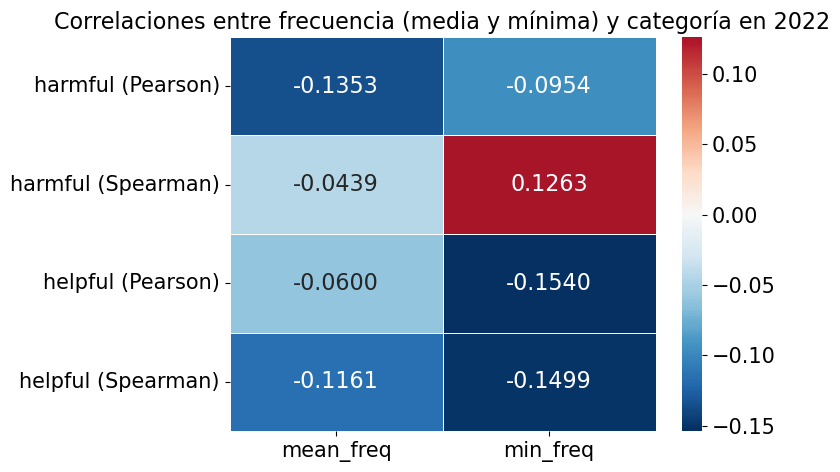

In [40]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    'mean_freq': {
        'harmful (Pearson)': pearsonr(mean_freq_2022['mean_freq'], mean_freq_2022['harmful'])[0],
        'harmful (Spearman)': spearmanr(mean_freq_2022['mean_freq'], mean_freq_2022['harmful'])[0],
        'helpful (Pearson)': pearsonr(mean_freq_2022['mean_freq'], mean_freq_2022['helpful'])[0],
        'helpful (Spearman)': spearmanr(mean_freq_2022['mean_freq'], mean_freq_2022['helpful'])[0],
    },
    'min_freq': {
        'harmful (Pearson)': pearsonr(min_freq_2022['min_freq'], min_freq_2022['harmful'])[0],
        'harmful (Spearman)': spearmanr(min_freq_2022['min_freq'], min_freq_2022['harmful'])[0],
        'helpful (Pearson)': pearsonr(min_freq_2022['min_freq'], min_freq_2022['helpful'])[0],
        'helpful (Spearman)': spearmanr(min_freq_2022['min_freq'], min_freq_2022['helpful'])[0],
    }
}

# Convertimos a DataFrame para visualización
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre frecuencia (media y mínima) y categoría en 2022")
plt.tight_layout()
plt.show()

**CONCLUSIONES:** `Comparativa de correlaciones 2020, 2021 y 2022`

`Correlaciones en 2020`

| Medida                  | `mean_freq` | `min_freq` |
|-------------------------|-------------|------------|
| harmful (Pearson)       | -0.1759     | -0.0702    |
| harmful (Spearman)      | -0.1191     | **0.2822** |
| helpful (Pearson)       | -0.1575     | -0.1178    |
| helpful (Spearman)      | -0.1694     | -0.0676    |

`Correlaciones en 2021`

| Medida                  | `mean_freq` | `min_freq` |
|-------------------------|-------------|------------|
| harmful (Pearson)       | **0.4287**  | -0.2103    |
| harmful (Spearman)      | 0.1807  | **-0.3101**    |
| helpful (Pearson)       | **-0.2953**   | 0.2794 |
| helpful (Spearman)      | -0.2641     | 0.1756 |

`Correlaciones en 2022`

| Medida                  | `mean_freq` | `min_freq` |
|-------------------------|-------------|------------|
| harmful (Pearson)       | -0.1353     | -0.0954    |
| harmful (Spearman)      | -0.0439     | 0.1263 |
| helpful (Pearson)       | -0.0600     | **-0.1540** |
| helpful (Spearman)      | -0.1161     | -0.1499    |

---

Las correlaciones en general son más débiles que en años anteriores. Ninguna supera un valor absoluto de **0.15**, lo que indica muy poca relación entre la frecuencia de las palabras y la categoría (harmful o helpful).

---

 A lo largo de los años, se observa una **normalización progresiva del lenguaje en el contenido `harmful`**, que ha pasado de usar palabras raras y detectables (2020) a emplear **vocabulario común y difícil de distinguir** (2022).  

Esto dificulta la identificación automática basada solo en frecuencia léxica, especialmente desde 2022, donde ambas variables (`mean_freq`, `min_freq`) pierden su utilidad como señales claras.

# Guardar datasets.

In [ ]:
qrels_2020_freq.to_csv("datasets/freq/qrels_2020_freq.csv", index=False)
qrels_2021_freq.to_csv("datasets/freq/qrels_2021_freq.csv", index=False)
qrels_2022_freq.to_csv("datasets/freq/qrels_2022_freq.csv", index=False)